In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

from utils import *

/home/wanhr/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename = "~/Documents/data/cos513/5G_Traffic_Datasets/Game_Streaming/GeForce_Now/GeForce_Now_2.csv"
local_ip = "10.215.173.1"

In [3]:
df = load_csv(filename)
# stats_src_ip(df)
# stats_dst_ip(df)
dl_pkts = extract_dl_pkt_interval_time(df, local_ip)
ul_pkts = extract_ul_pkt_interval_time(df, local_ip)

In [4]:
dl_pkt_interval = dl_pkts[dl_pkts[:, 0] < 0.05, :]
ul_pkt_interval = ul_pkts[ul_pkts[:, 0] < 0.05, :]

dl_pkt_interval[:, 0] = dl_pkt_interval[:, 0] * 1000
ul_pkt_interval[:, 0] = ul_pkt_interval[:, 0] * 1000

dl_count, dl_bins_count = np.histogram(dl_pkt_interval[:, 0], bins=10000) 
dl_pdf = dl_count / sum(dl_count) 
dl_cdf = np.cumsum(dl_pdf) 

ul_count, ul_bins_count = np.histogram(ul_pkt_interval[:, 0], bins=10000) 
ul_pdf = ul_count / sum(ul_count) 
ul_cdf = np.cumsum(ul_pdf) 

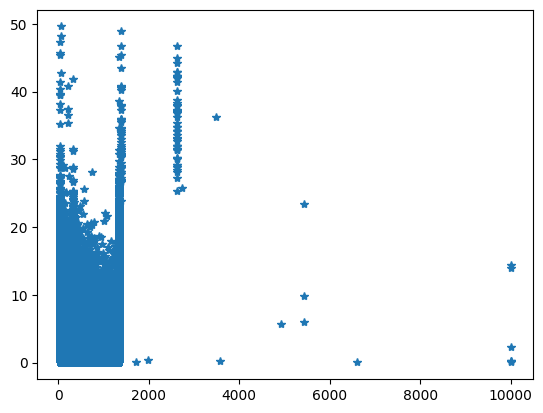

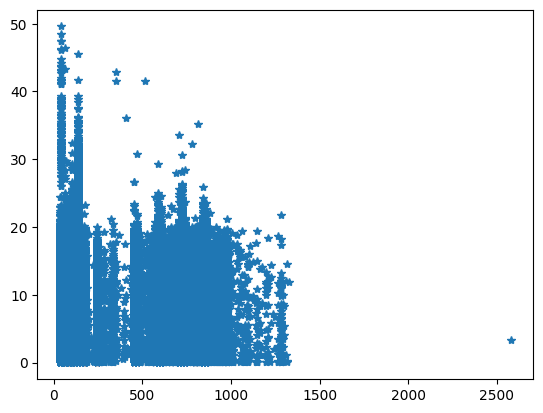

In [5]:
plt.figure()
plt.plot(dl_pkt_interval[:, 2], dl_pkt_interval[:, 0], '*')

plt.figure()
plt.plot(ul_pkt_interval[:, 2], ul_pkt_interval[:, 0], "*")

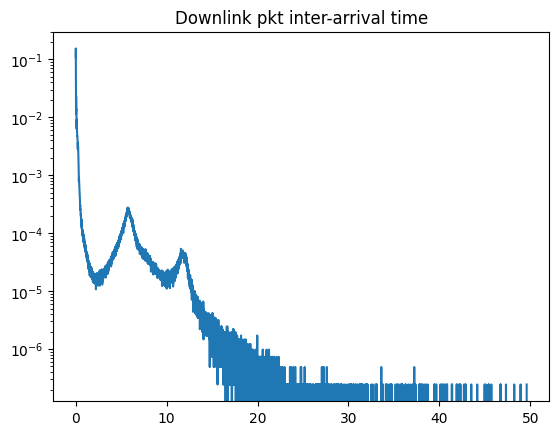

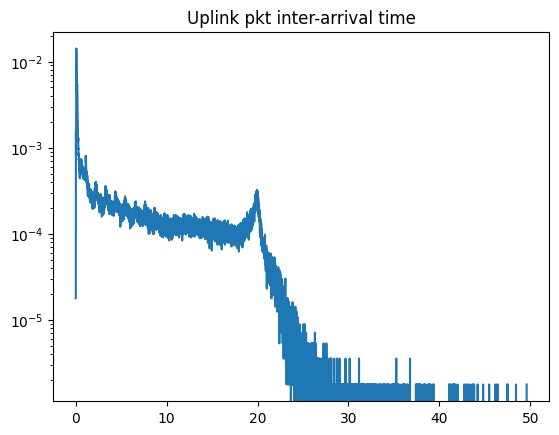

In [6]:
plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf)
plt.yscale("log")
plt.title("Uplink pkt inter-arrival time")

plt.show()

In [7]:
train = torch.tensor(dl_pkt_interval, dtype=torch.float)
pkt_interval, time, pkt_size = train[:, 0], train[:, 1], train[:, 2]

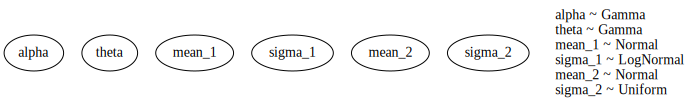

In [8]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

# def categorical_possion()

def model(pkt_size, pkt_interval=None):
    alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
    theta = pyro.sample("theta", dist.Gamma(1., 1.))
    gamma = dist.Gamma(alpha, theta)

    mean_1 = pyro.sample("mean_1", dist.Normal(5, 2))
    sigma_1 = pyro.sample("sigma_1", dist.LogNormal(0., 0.5))
    gaussian_1 = dist.Normal(mean_1, sigma_1)

    mean_2 = pyro.sample("mean_2", dist.Normal(12, 2))
    sigma_2 = pyro.sample("sigma_2", dist.Uniform(0., 0.5))
    gaussian_2 = dist.Normal(mean_2, sigma_2)

    cat_dist = dist.OneHotCategorical(torch.Tensor([0.9, 0.05, 0.05]))
    y = cat_dist.sample()

    gamma_samp = gamma.sample()
    gaussian_samp_1 = gaussian_1.sample()
    gaussian_samp_2 = gaussian_2.sample()
    
    with pyro.plate("data", len(time)):
        return y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2

pyro.render_model(model, model_args=(pkt_size, pkt_interval), render_distributions=True)

In [9]:
def custom_guide(pkt_size, pkt_interval=None):
    alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

    theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

    mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
    sigma_1_loc = pyro.param('sigma_1_loc', lambda: torch.tensor(0.))
    mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
    sigma_1 = pyro.sample('sigma_1', dist.LogNormal(sigma_1_loc, torch.tensor(0.005)))

    mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
    sigma_2_loc = pyro.param('sigma_2_loc', lambda: torch.tensor(0.))
    mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
    sigma_2 = pyro.sample('sigma_2', dist.LogNormal(sigma_2_loc, torch.tensor(0.005)))

    # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
    #                       constraint=constraints.positive)
    # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
    # y = pyro.sample('y', cat)

    return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
            'mean_2': mean_2, 'sigma_2': sigma_2}

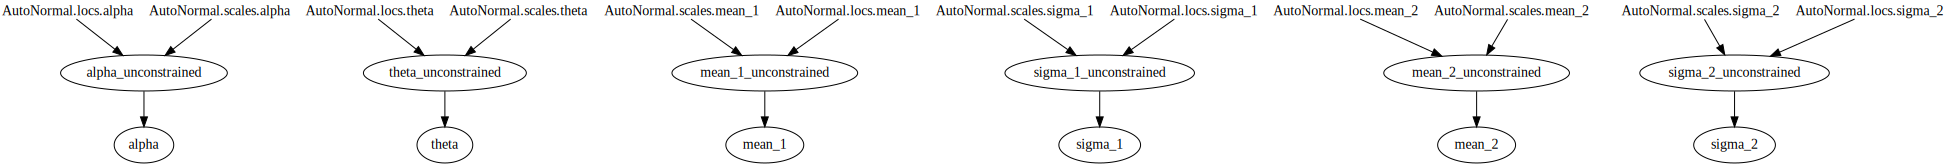

In [10]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

pyro.render_model(auto_guide, model_args=(pkt_size, pkt_interval), render_params=True)

In [11]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Step: 0, Elbo loss: 34.7183551620692
Step: 100, Elbo loss: 23.988321404904127
Step: 200, Elbo loss: 14.550460189580917
Step: 300, Elbo loss: 15.655279479920864
Step: 400, Elbo loss: 11.401355996727943
Step: 500, Elbo loss: 5.83894506841898
Step: 600, Elbo loss: 8.112334102392197
Step: 700, Elbo loss: 1.9523949027061462
Step: 800, Elbo loss: 0.3081223666667938
Step: 900, Elbo loss: 4.232036584988236
Step: 1000, Elbo loss: -4.705952674150467
Step: 1100, Elbo loss: 1.6633003037422895
Step: 1200, Elbo loss: 4.2381346225738525
Step: 1300, Elbo loss: -0.1649317741394043
Step: 1400, Elbo loss: 1.6591867879033089
Step: 1500, Elbo loss: -0.515071913599968
Step: 1600, Elbo loss: 2.3660334795713425
Step: 1700, Elbo loss: 0.07315059751272202
Step: 1800, Elbo loss: 1.9871667549014091
Step: 1900, Elbo loss: 0.7768210470676422
Step: 2000, Elbo loss: -1.3156361281871796
Step: 2100, Elbo loss: 0.37796634435653687
Step: 2200, Elbo loss: -0.5794304814189672
Step: 2300, Elbo loss: 0.48954305052757263
Step

Text(0, 0.5, 'ELBO loss')

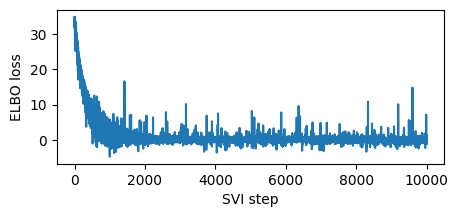

In [12]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.01})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(10000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

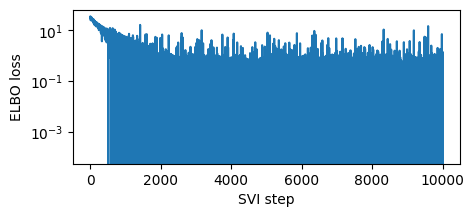

In [13]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [14]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha -0.5229783
AutoNormal.scales.alpha 0.9185775
AutoNormal.locs.theta -0.59935546
AutoNormal.scales.theta 0.9914188
AutoNormal.locs.mean_1 4.945682
AutoNormal.scales.mean_1 2.079052
AutoNormal.locs.sigma_1 -0.110651314
AutoNormal.scales.sigma_1 0.5192051
AutoNormal.locs.mean_2 11.904765
AutoNormal.scales.mean_2 2.1237817
AutoNormal.locs.sigma_2 -0.18176173
AutoNormal.scales.sigma_2 1.8394216


In [ ]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1000)
svi_samples = predictive(pkt_size, pkt_interval=None)
cat_dist = dist.OneHotCategorical(torch.Tensor([0.9, 0.05, 0.05]))
y = cat_dist.sample()

res = []
for i in range(svi_samples['alpha'].shape[0]):
  gamma_samp = dist.Gamma(svi_samples['alpha'][i], svi_samples['theta'][i]).sample()
  gaussian_samp_1 = dist.Normal(svi_samples['mean_1'][i], svi_samples['sigma_1'][i]).sample()
  gaussian_samp_2 = dist.Normal(svi_samples['mean_2'][i], svi_samples['sigma_2'][i]).sample()
  cat_dist = dist.OneHotCategorical(torch.Tensor([0.9, 0.05, 0.05]))
  y = cat_dist.sample()
  res.append(y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2)

print(res)

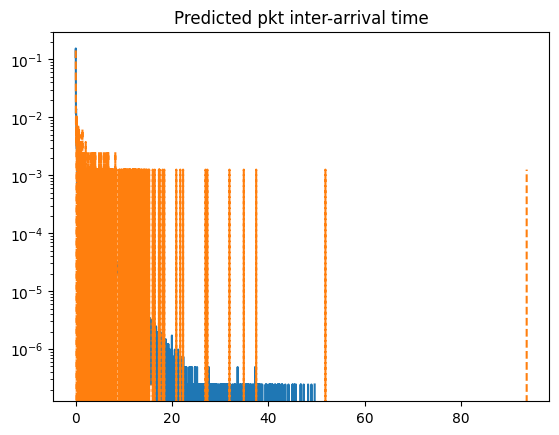

In [ ]:
res = np.array(res)

res_count, res_bins_count = np.histogram(res, bins=10000) 
res_pdf = res_count / sum(res_count) 
res_cdf = np.cumsum(res_pdf) 

plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

plt.plot(res_bins_count[1:], res_pdf, '--')
plt.yscale("log")
plt.title("Predicted pkt inter-arrival time")

plt.show()